## Necessary imports

In [1]:
import math, re, os
import numpy as np
import tensorflow as tf
import warnings 
warnings.filterwarnings("ignore")

print("Tensorflow version " + tf.__version__)

D0512 07:55:32.523932529      14 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0512 07:55:32.523968088      14 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0512 07:55:32.523978506      14 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0512 07:55:32.523981652      14 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0512 07:55:32.523984316      14 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0512 07:55:32.523988257      14 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0512 07:55:32.523990980      14 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0512 07:55:32.

Tensorflow version 2.12.0


In [2]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


REPLICAS:  8


## Loading data

Data pipelines and exploration functions based on notebook: https://www.kaggle.com/code/achinih/flower-classification-cnn-models

In [3]:
import re
import numpy as np
import tensorflow as tf

from kaggle_datasets import KaggleDatasets

class DataLoad(tf.data.TFRecordDataset): # tf.data.TFRecordDataset
    
    AUTO = tf.data.experimental.AUTOTUNE
    
    def __init__(self, image_size=512, batch_size=16):
        
        self.BATCH_SIZE = batch_size
        
        assert image_size in (192,224,331,512)
        self.IMAGE_SIZE = [image_size, image_size]
        
        self.GCS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started') + f'/tfrecords-jpeg-{image_size}x{image_size}'
        self.TRAINING_FILENAMES = tf.io.gfile.glob(self.GCS_PATH + '/train/*.tfrec')
        self.VALIDATION_FILENAMES = tf.io.gfile.glob(self.GCS_PATH + '/val/*.tfrec')
        self.TEST_FILENAMES = tf.io.gfile.glob(self.GCS_PATH + '/test/*.tfrec')
        
        self.NUM_TRAINING_IMAGES = self.count_data_items(self.TRAINING_FILENAMES)
        self.NUM_VALIDATION_IMAGES = self.count_data_items(self.VALIDATION_FILENAMES)
        self.NUM_TEST_IMAGES = self.count_data_items(self.TEST_FILENAMES)
        
        self.TRAINING_STEPS_PER_EPOCH = self.NUM_TRAINING_IMAGES // self.BATCH_SIZE
        self.TEST_STEPS_PER_EPOCH = self.NUM_TEST_IMAGES // self.BATCH_SIZE
        
        self.CLASSES = ['pink primrose',        'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',      'wild geranium',         # 00 - 04
                        'tiger lily',           'moon orchid',               'bird of paradise', 'monkshood',      'globe thistle',         # 05 - 09
                        'snapdragon',           "colt's foot",               'king protea',      'spear thistle',  'yellow iris',           # 10 - 14
                        'globe-flower',         'purple coneflower',         'peruvian lily',    'balloon flower', 'giant white arum lily', # 15 - 19
                        'fire lily',            'pincushion flower',         'fritillary',       'red ginger',     'grape hyacinth',        # 20 - 24
                        'corn poppy',           'prince of wales feathers',  'stemless gentian', 'artichoke',      'sweet william',         # 25 - 29
                        'carnation',            'garden phlox',              'love in the mist', 'cosmos',         'alpine sea holly',      # 30 - 34
                        'ruby-lipped cattleya', 'cape flower',               'great masterwort', 'siam tulip',     'lenten rose',           # 35 - 39
                        'barberton daisy',      'daffodil',                  'sword lily',       'poinsettia',     'bolero deep blue',      # 40 - 44
                        'wallflower',           'marigold',                  'buttercup',        'daisy',          'common dandelion',      # 45 - 49
                        'petunia',              'wild pansy',                'primula',          'sunflower',      'lilac hibiscus',        # 50 - 54
                        'bishop of llandaff',   'gaura',                     'geranium',         'orange dahlia',  'pink-yellow dahlia',    # 55 - 59
                        'cautleya spicata',     'japanese anemone',          'black-eyed susan', 'silverbush',     'californian poppy',     # 60 - 64
                        'osteospermum',         'spring crocus',             'iris',             'windflower',     'tree poppy',            # 65 - 69
                        'gazania',              'azalea',                    'water lily',       'rose',           'thorn apple',           # 70 - 74
                        'morning glory',        'passion flower',            'lotus',            'toad lily',      'anthurium',             # 75 - 79
                        'frangipani',           'clematis',                  'hibiscus',         'columbine',      'desert-rose',           # 80 - 84
                        'tree mallow',          'magnolia',                  'cyclamen ',        'watercress',     'canna lily',            # 85 - 89
                        'hippeastrum ',         'bee balm',                  'pink quill',       'foxglove',       'bougainvillea',         # 90 - 94
                        'camellia',             'mallow',                    'mexican petunia',  'bromelia',       'blanket flower',        # 95 - 99
                        'trumpet creeper',      'blackberry lily',           'common tulip',     'wild rose']                               # 100 - 103
    
    def count_data_items(self, filenames):
        n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
        return np.sum(n)

    #processing the images into floats from 0,1 and reshaping to the size required for a TPU.
    def decode_image(self, image_data):
        image = tf.image.decode_jpeg(image_data, channels=3)
        image = tf.cast(image, tf.float32) / 255.0
        image = tf.reshape(image, [*self.IMAGE_SIZE, 3])
        return image
    
    #reading the labels for my images and returns a dataset with the image and label in a pair.
    def read_labeled_tfrecord(self, example):
        LABELED_TFREC_FORMAT = {
            "image": tf.io.FixedLenFeature([], tf.string),
            "class": tf.io.FixedLenFeature([], tf.int64),
        }
        example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
        image = self.decode_image(example['image'])
        label = tf.cast(example['class'], tf.int32)
        return image, label
    
    #reading the unlabeled data to use for testing.
    def read_unlabeled_tfrecord(self, example):
        UNLABELED_TFREC_FORMAT = {
            "image": tf.io.FixedLenFeature([], tf.string),
            "id": tf.io.FixedLenFeature([], tf.string),
        }
        example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
        image = self.decode_image(example['image'])
        idnum = example['id']
        return image, idnum

    #Reading multiple files at once to improve performance. 
    #Ordering data order decreases the speed and as the data will be shuffled later on anyways. 
    def load_dataset(self, filenames, labeled=True, ordered=False):
    
        ignore_order = tf.data.Options()
        if not ordered:
            ignore_order.experimental_deterministic = False # disabling order

        dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=self.AUTO)
        dataset = dataset.with_options(ignore_order)
        dataset = dataset.map(self.read_labeled_tfrecord if labeled else self.read_unlabeled_tfrecord, num_parallel_calls=self.AUTO)
        # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
        return dataset
    
    def get_training_dataset(self, data_augment=True, ordered=False):
        dataset = self.load_dataset(self.TRAINING_FILENAMES, labeled=True, ordered=ordered)
        dataset = dataset.repeat(10)
        if data_augment:
            dataset = dataset.map(data_augment, num_parallel_calls=self.AUTO)
        else:
            dataset = dataset.map(no_data_augment, num_parallel_calls=self.AUTO)
        dataset = dataset.repeat() # the training dataset must repeat for several epochs
        dataset = dataset.shuffle(2048)
        dataset = dataset.batch(self.BATCH_SIZE)
        dataset = dataset.prefetch(self.AUTO) # get next batch while training
        return dataset
    
    def get_validation_dataset(self, ordered=False):
        dataset = self.load_dataset(self.VALIDATION_FILENAMES, labeled=True, ordered=ordered)
        dataset = dataset.batch(self.BATCH_SIZE)
        dataset = dataset.cache()
        dataset = dataset.prefetch(self.AUTO)
        return dataset
    
    def get_test_dataset(self, ordered=False):
        dataset = self.load_dataset(self.TEST_FILENAMES, labeled=False, ordered=ordered)
#         dataset = dataset.batch(self.BATCH_SIZE)
        dataset = dataset.prefetch(self.AUTO)
        return dataset

## History visualization

In [4]:
from matplotlib import pyplot as plt

def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: 
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

## More visualisation helpers

In [5]:
def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case,
                                     # these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is
    # the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return data_load.CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(data_load.CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                data_load.CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square
    # or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else data_load.CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()
    
def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='YlGn')
    ax.set_xticks(range(len(data_load.CLASSES)))
    ax.set_xticklabels(data_load.CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(data_load.CLASSES)))
    ax.set_yticklabels(data_load.CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()

# Model to implement

The data will load to data_load based on chosen `IMAGE_SIZE` and `BATCH_SIZE`. Then the model has to be compiled within `strategy.scope()`, compiled with chosen `optimizer`, `loss`, and `metrics`.

In [6]:
def data_augment(image, label):
    #data augmentation to prevent overfitting and to find more patterns.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_flip_up_down(image)
    image = tf.image.random_saturation(image, 0, 2)
    #image = tf.image.random_brightness(image, 0.2)
    return image, label

def no_data_augment(image, label):
    #No augmentation function added just to make this option possible for later visualisations of the augmentation changes
    return image, label

In [7]:
image_size = 224
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

IMAGE_SIZE = [image_size, image_size]

data_load = DataLoad(image_size=image_size, batch_size=BATCH_SIZE)

ds_train = data_load.get_training_dataset(data_augment=data_augment)
ds_valid = data_load.get_validation_dataset()
ds_test = data_load.get_test_dataset()

get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/tpu-getting-started


In [8]:
"""
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten

gu_seed = tf.keras.initializers.GlorotUniform(seed=1)

with strategy.scope():
    pretrained_model = tf.keras.applications.vgg16.VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=[*IMAGE_SIZE, 3],
        classes=len(data_load.CLASSES),
        classifier_activation='softmax'
    )
    pretrained_model.trainable = False
    
    for layer in pretrained_model.layers[15:]:
        layer.trainable = True
    
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(1024, activation="relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(2048, activation="relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2048, activation="relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(1024, activation="relu"),
        tf.keras.layers.BatchNormalization(),  
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(len(data_load.CLASSES), activation='softmax')
    ])
"""

'\nfrom tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten\n\ngu_seed = tf.keras.initializers.GlorotUniform(seed=1)\n\nwith strategy.scope():\n    pretrained_model = tf.keras.applications.vgg16.VGG16(\n        weights=\'imagenet\',\n        include_top=False,\n        input_shape=[*IMAGE_SIZE, 3],\n        classes=len(data_load.CLASSES),\n        classifier_activation=\'softmax\'\n    )\n    pretrained_model.trainable = False\n    \n    for layer in pretrained_model.layers[15:]:\n        layer.trainable = True\n    \n    model = tf.keras.Sequential([\n        pretrained_model,\n        tf.keras.layers.GlobalAveragePooling2D(),\n        tf.keras.layers.BatchNormalization(),  \n        tf.keras.layers.Dropout(0.25),\n        tf.keras.layers.Dense(1024, activation="relu"),\n        tf.keras.layers.BatchNormalization(),  \n        tf.keras.layers.Dropout(0.25),\n        tf.keras.layers.Dense(2048, activation="relu"),\n        tf.keras.layers.BatchNormaliz

In [9]:
from tensorflow.keras import layers, callbacks

with strategy.scope():
#     pretrained_model = tf.keras.applications.InceptionResNetV2(
#     weights = 'imagenet', 
#     include_top = False, 
#     input_shape = [*IMAGE_SIZE, 3])

#     pretrained_model = tf.keras.applications.MobileNetV2(
#         weights = 'imagenet', 
#         include_top = False, 
#         input_shape = [*IMAGE_SIZE, 3])
    
#     pretrained_model = tf.keras.applications.ResNet152V2(
#         weights = 'imagenet', 
#         include_top = False, 
#         input_shape = [*IMAGE_SIZE, 3])
    
#     pretrained_model = tf.keras.applications.InceptionV3(
#         weights = 'imagenet', 
#         include_top = False, 
#         input_shape = [*IMAGE_SIZE, 3])
    
#     pretrained_model = efficientnet.EfficientNetB7(
#         weights = 'noisy-student', 
#         include_top = False, 
#         input_shape = [*IMAGE_SIZE, 3])
    
    pretrained_model = tf.keras.applications.DenseNet201(
        weights = 'imagenet', 
        include_top = False, 
        input_shape = [*IMAGE_SIZE, 3])
        
#     pretrained_model = tf.keras.applications.xception.Xception(
#         weights='imagenet',
#         include_top=False ,
#         input_shape=[*IMAGE_SIZE, 3]
#     )

    pretrained_model.trainable = True
    
    model = tf.keras.Sequential([        
        # To a base pretrained on ImageNet to extract features from images...
        pretrained_model,
        # ... attach a new head to act as a classifier.
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(data_load.CLASSES), activation='softmax')
    ])

74836368/74836368 [==============================] - 0s 0us/step


In [10]:
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.005, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 104)               199784    
                                                                 
Total params: 18,521,768
Trainable params: 18,292,712
Non-trainable params: 229,056
_________________________________________________________________


Now it is possible to augment the images within `data_augment` function, pick the number of `EPOCHS`, and fit the model.

### Augmentation visualisation

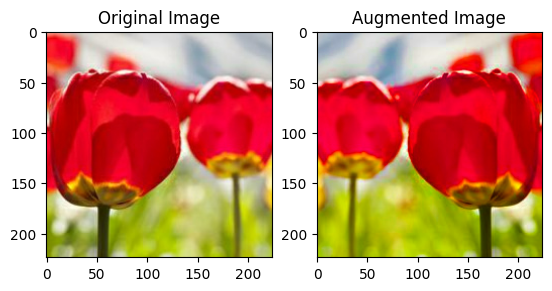

In [24]:
#This is really slow

from itertools import islice

ds_train_original = data_load.get_training_dataset(data_augment = no_data_augment, ordered = True)
ds_train_no_augment = ds_train_original.take(1).cache().repeat()
ds_train_augment = ds_train_no_augment.map(data_augment)

index = 100 # Use the same index for both datasets
augmented_images, labels = next(islice(ds_train_augment, index, None))
original_images, labels = next(islice(ds_train_no_augment, index, None))

# augmented_images, labels = next(iter(ds_train_augment.skip(index).take(1)))
# original_images, labels = next(iter(ds_train_no_augment.skip(index).take(1)))

fig, axes = plt.subplots(ncols=2)
axes[0].imshow(original_images[0].numpy())
axes[0].set_title("Original Image")
axes[1].imshow(augmented_images[0].numpy())
axes[1].set_title("Augmented Image")
plt.show()

## Training

In [12]:
EPOCHS = 30
STEPS_PER_EPOCH = data_load.TRAINING_STEPS_PER_EPOCH

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    #callbacks=[lr_callback, early_stopping],
    callbacks=[early_stopping]
    #class_weight = weight_per_class #tuning11
)

Epoch 1/30


2023-05-12 08:07:43.201972: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-05-12 08:07:45.720967: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


KeyboardInterrupt: 

In [ ]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

In [ ]:
np.save('history.npy',history.history)
model.save('model')

## Confusion matrix

In [ ]:
!pip install -U scikit-learn

In [ ]:
from sklearn.metrics import confusion_matrix

# Load validation dataset from DataLoad object
cmdataset = data_load.get_validation_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

# Get correct labels and model predictions
cm_correct_labels = next(iter(labels_ds.batch(data_load.NUM_VALIDATION_IMAGES))).numpy()
cm_probabilities = model.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)

# Compute confusion matrix and normalize
labels = range(len(data_load.CLASSES))
cmat = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
)
cmat = (cmat.T / cmat.sum(axis=1)).T


In [ ]:

from sklearn.metrics import f1_score, precision_score, recall_score

score = f1_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
precision = precision_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
recall = recall_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
display_confusion_matrix(cmat, score, precision, recall)


In [ ]:
"""
#OLD VERSION

import matplotlib.pyplot as plt
import numpy as np

# define class names
classes = data_load.CLASSES

# create figure and axes objects
fig, ax = plt.subplots(figsize=(10, 10))

# plot confusion matrix
im = ax.imshow(cmat, interpolation='nearest', cmap=plt.cm.YlGn)
ax.figure.colorbar(im, ax=ax)

# set axes labels and tick marks
ax.set(xticks=np.arange(cmat.shape[1]),
       yticks=np.arange(cmat.shape[0]),
       xticklabels=classes, yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label')

# rotate x tick labels to avoid overlap
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# annotate each cell with its count
for i in range(cmat.shape[0]):
    for j in range(cmat.shape[1]):
        ax.text(j, i, format(cmat[i, j], '.2f'),
                ha="center", va="center",
                color="white" if cmat[i, j] > cmat.max() / 2. else "black")

# set plot title
ax.set_title("Normalized confusion matrix")

# display plot
plt.show()
"""

In [ ]:

#Since the entire matrix is too large to be visualised at once I made an example subset of it

# Define class names
class_names = data_load.CLASSES[:10]

# Get confusion matrix for first 10 classes
cmat_subset = cmat[:10, :10]

# Normalize confusion matrix
#cmat_subset = (cmat_subset.T / cmat_subset.sum(axis=1)).T

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cmat_subset, cmap='YlGn')

# Show all ticks
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))

# Label ticks with class names
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

# Rotate x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Axis names
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

# Loop over data dimensions and create text annotations.
for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = ax.text(j, i, "{:.2f}".format(cmat_subset[i, j]),
                       ha="center", va="center", color="black")

# Set plot title and colorbar
ax.set_title("Confusion Matrix (Subset)", fontsize=16)
plt.colorbar(im)
plt.show()


## Visual validation

In [ ]:

dataset = cmdataset.unbatch().batch(20)
batch = iter(dataset)


In [ ]:

images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)


# Predictions to submit

In [ ]:
print('Computing predictions...')
test_images_ds = ds_test.map(lambda image, idnum: image).batch(BATCH_SIZE)
probabilities = model.predict(test_images_ds, steps=data_load.TEST_STEPS_PER_EPOCH+1)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

In [ ]:
print('Generating submission.csv file...')
test_ids_ds = ds_test.map(lambda image, idnum: idnum)
test_ids = next(iter(test_ids_ds.batch(data_load.NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')

# Submitting

If you haven't already, create your own editable copy of this notebook by clicking on the Copy and Edit button in the top right corner. Then, submit to the competition by following these steps:

1. Begin by clicking on the blue Save Version button in the top right corner of the window. This will generate a pop-up window.
2. Ensure that the Save and Run All option is selected, and then click on the blue Save button.
3. This generates a window in the bottom left corner of the notebook. After it has finished running, click on the number to the right of the Save Version button. This pulls up a list of versions on the right of the screen. Click on the ellipsis (...) to the right of the most recent version, and select Open in Viewer. This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the Output tab on the right of the screen. Then, click on the file you would like to submit, and click on the blue Submit button to submit your results to the leaderboard.

You have now successfully submitted to the competition!